Loading FastText model...
Generating embeddings for full dataset...


100%|██████████| 18082/18082 [00:00<00:00, 36710.33it/s]


Before SMOTE: [15505  2577]
After SMOTE: [15505 15505]
Train-Test Split: 80% Train, 20% Test


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model...
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1: Loss=0.3242, Accuracy=0.8626, F1 Score=0.8683
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 2: Loss=0.2737, Accuracy=0.8828, F1 Score=0.8879
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 3: Loss=0.2547, Accuracy=0.8968, F1 Score=0.8985
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 4: Loss=0.2272, Accuracy=0.9089, F1 Score=0.9093
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 5: Loss=0.2539, Accuracy=0.8976, F1 Score=0.8934
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 6: Loss=0.2076, Accuracy=0.9174, F1 Score=0.9200
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 7: Loss=0.1993, Accuracy=0.9245, F1 Score=0.9276
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 8: Loss=0.1885, Accuracy=0.9268, F1 Score=0.9293
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 9: Loss=0.1779, Accuracy=0.9386, F1 Score=0.9399
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 10: Loss=0.2018, Accuracy=0.9208, F1 Score=0.9253
194/194 ━━━━━━━━━━━━━

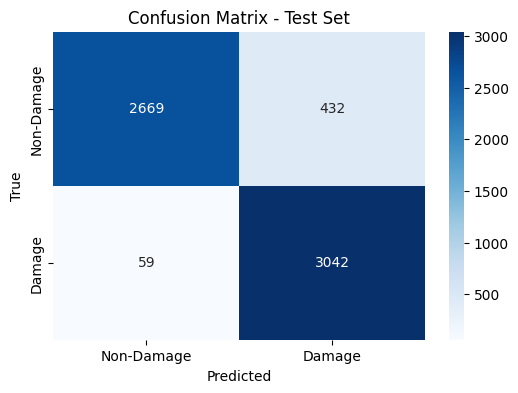

In [18]:
# ========== Imports ==========
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# ========== Preprocess Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
df['Processed_data'] = df['Processed_data'].fillna("")

# ========== Load FastText Model ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Function to Create Document Embeddings ==========
def get_avg_embedding(text, model, dim):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(dim)

# ========== Generate Embeddings for Full Dataset ==========
print("Generating embeddings for full dataset...")
X_full = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(df['Processed_data'])])
y_full = df['Binary_class'].values

# ========== Apply SMOTE to the Full Data Before Splitting ==========
print("Before SMOTE:", np.bincount(y_full))
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_resampled, y_resampled = smote.fit_resample(X_full, y_full)
print("After SMOTE:", np.bincount(y_resampled))

# ========== Split Resampled Data ==========
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.20, stratify=y_resampled, random_state=42
)
print("Train-Test Split: 80% Train, 20% Test")

# ========== Custom Callback to Track Metrics on Test Set ==========
class MetricsCallback(Callback):
    def __init__(self, X_test, y_test):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs=None):
        # Predict on test data at the end of each epoch
        test_preds = (self.model.predict(self.X_test) > 0.5).astype(int)
        
        # Calculate F1 Score
        f1 = f1_score(self.y_test, test_preds)
        
        # Print accuracy, loss, and F1 score on the test set
        test_loss, test_accuracy = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        print(f"Epoch {epoch+1}: Loss={test_loss:.4f}, Accuracy={test_accuracy:.4f}, F1 Score={f1:.4f}")

# ========== Build Neural Network Model ==========
model = Sequential([
    Dense(256, activation='relu', input_shape=(embedding_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# ========== Train the Model ==========
print("Training model...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    verbose=0,  # Set verbose=0 to suppress output
    validation_data=(X_test, y_test),
    callbacks=[MetricsCallback(X_test, y_test)]
)

# ========== Final Evaluation on Test Set ==========
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
test_preds = (model.predict(X_test) > 0.5).astype(int)
test_proba = model.predict(X_test)
test_roc_auc = roc_auc_score(y_test, test_proba)
test_f1 = f1_score(y_test, test_preds)
test_report = classification_report(y_test, test_preds, target_names=['Non-Damage', 'Damage'])

print("\n📊 Final Evaluation Summary:")
print(f"✅ Accuracy   : {test_accuracy:.4f}")
print(f"✅ ROC-AUC    : {test_roc_auc:.4f}")
print(f"✅ F1 Score   : {test_f1:.4f}")
print("✅ Classification Report:\n", test_report)

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()
